In [1]:
#import & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 9)

df_apps = pd.read_csv('googleplaystore_origin.csv')
df_apps.head()

Populating the interactive namespace from numpy and matplotlib


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [2]:
for col in df_apps.columns:
    print(col, type(df_apps[col][1]))

App <class 'str'>
Category <class 'str'>
Rating <class 'numpy.float64'>
Reviews <class 'str'>
Size <class 'str'>
Installs <class 'str'>
Type <class 'str'>
Price <class 'str'>
Content Rating <class 'str'>
Genres <class 'str'>
Last Updated <class 'str'>
Current Ver <class 'str'>
Android Ver <class 'str'>


In [3]:
#row 10472 doesn't have value for category; its following values are shifted
#shift the row to make it right
df_apps.iloc[10472] = df_apps.iloc[10472].shift(1)
df_apps.loc[10472, 'App'] = df_apps.loc[10472, 'Category']
df_apps.loc[10472, 'Category'] = ''

In [4]:
#data type transformations
def to_int(x):
    if ''.join(str(x).split('.')).isdigit():
        return int(x)
    else:
        print('not digit',x)
        
def size_to_float(x):
    if len(str(x))>0:
        out = 0.0
        if x[-1] in ['M','m']:
            out = float(''.join(x[:-1].split('.'))) * 1000
        elif x[-1] in ['K','k']:
            out = float(''.join(x[:-1].split('.')))
        else:
            out = -1
        return out
    else:
        return 0
    
def install_to_int(x):
    if x[-1] == '+':
        return int(''.join(x[:-1].split(',')))
    else:
        return 0
    
def price_to_float(x):
    if x[0] == '$':
        return float(''.join(x[1:].split('.')))
    else:
        return 0.0
    
def str_to_date(x):
    try:
        dt = parser.parse(x)
        return dt
    except:
        print('problem date:', x)
    
df_apps.Reviews = df_apps.Reviews.apply(to_int)
df_apps.Size = df_apps.Size.apply(size_to_float)

#keeping original Installs column
df_apps['installs_int'] = df_apps.Installs.apply(install_to_int)
df_apps.Price = df_apps.Price.apply(price_to_float)
df_apps['Last Updated'] = df_apps['Last Updated'].apply(str_to_date)

In [5]:
#encode Category only
#not encoding type, since price will be 0 if type is free
#not using Genre for now
#compare different methods of encoding, do it later

df_apps.Category.unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION', ''], dtype=object)

In [6]:
#what's up with the repititions?
#it appears that data on the same app might have been collected mulitple times
#only keep the record with the largest number of reviews

print(len(df_apps), len(df_apps.App.unique()))
duplications = df_apps.App.value_counts()[df_apps.App.value_counts() > 1]


for app in duplications.keys():
    appearances = df_apps[df_apps.App == app]
    drop_i = appearances.sort_values('Reviews', ascending=False).index[1:]
    df_apps.drop(drop_i, inplace=True)
    
print(len(df_apps), len(df_apps.App.unique()))

10841 9660
9660 9660


In [7]:
#excluding apps with less than 5000 installs
drop_i = df_apps[df_apps.installs_int < 5000].index
df_apps.drop(drop_i, inplace=True)
len(df_apps)

6982

In [8]:
#construct extra columns

#reviews per install
df_apps['reviews_per_install'] = df_apps.Reviews/df_apps.installs_int

#days from last update to 20180831
end_date = datetime.datetime(2018,8,31,0,0,0)
def get_delta(x):
    d = end_date - x
    return d.days
df_apps['updated_delta'] = df_apps['Last Updated'].apply(get_delta)

In [9]:
s = df_apps['Category'].value_counts()
thr = 4

tops = s[:thr-1]
tops['others'] = s[thr-1:].sum()
print(tops)

n = 0
for item in s[3:]:
    n+= item
    
n
df_apps.columns

FAMILY    1360
GAME       834
TOOLS      603
others    4185
Name: Category, dtype: int64


Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver', 'installs_int', 'reviews_per_install', 'updated_delta'],
      dtype='object')

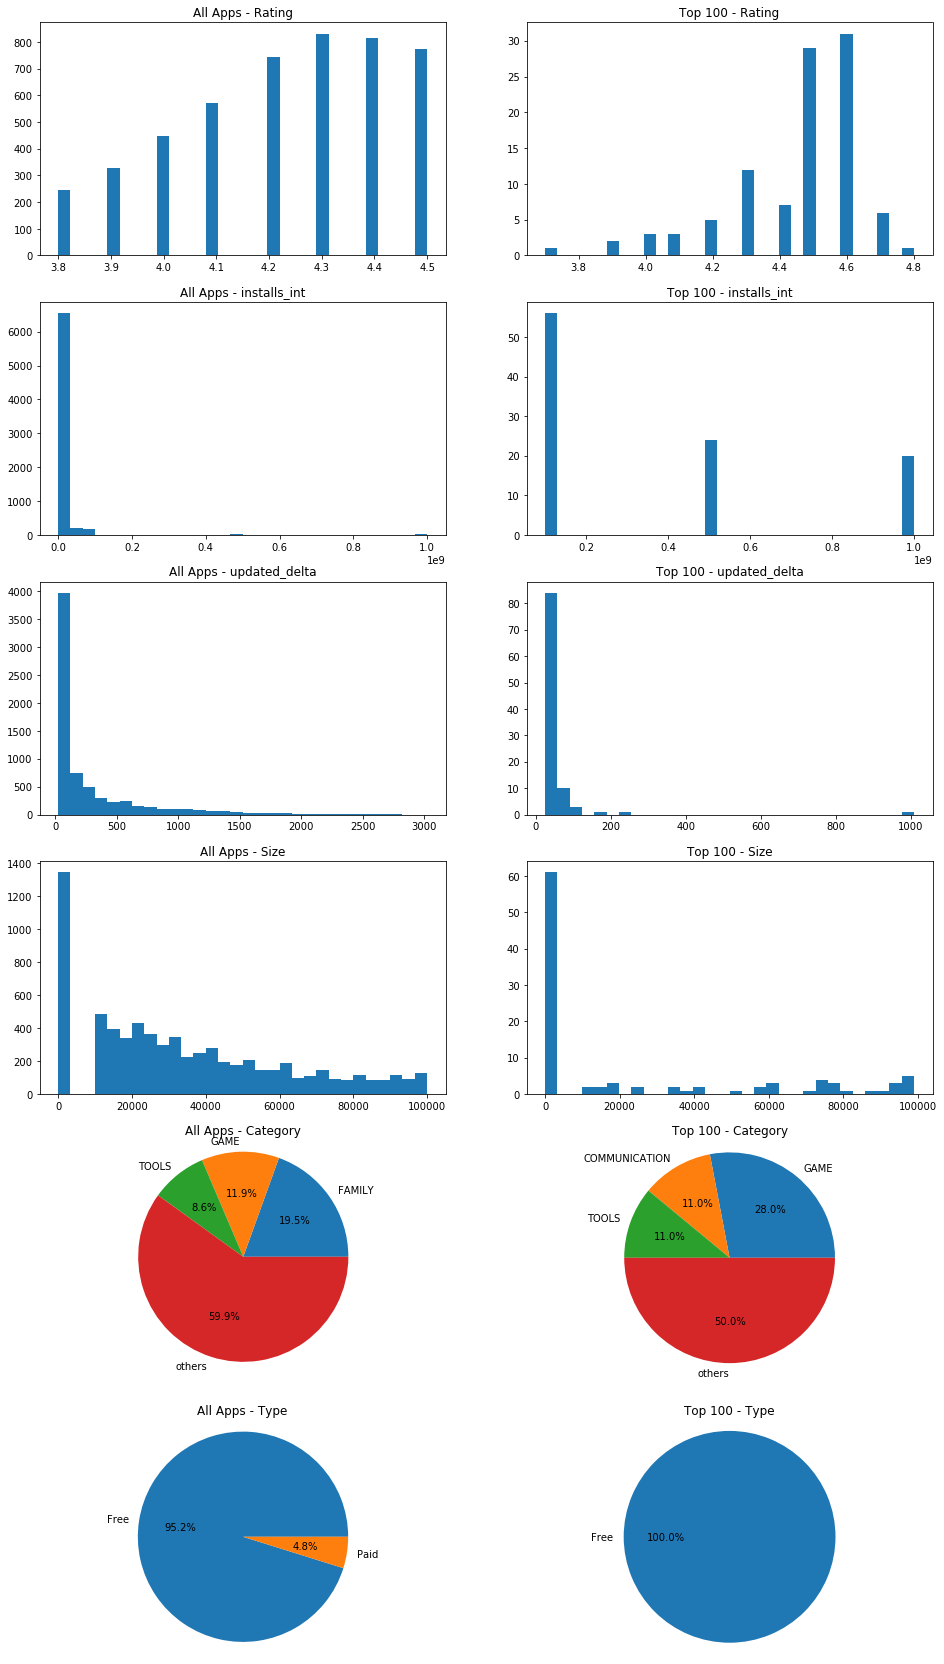

In [10]:
#comparisons of top100 and all
pylab.rcParams['figure.figsize'] = (16, 30)

#picking out the best apps
df_apps['rating_installs'] = df_apps.Rating * df_apps.installs_int
top_100 = df_apps.sort_values('rating_installs', ascending=False)[:100]

def comp_hist(col, ax):
    ax[0].hist(df_apps[col], bins=30)
    ax[0].set_title(col)
    ax[0].set_title('All Apps - {}'.format(col))
    ax[1].hist(top_100[col], bins=30)
    ax[1].set_title(col)
    ax[1].set_title('Top 100 - {}'.format(col))
    
def get_cate_counts(d, col):
    thres = 4
    cate_counts = d[col].value_counts()
    if len(cate_counts) > thres:
        tops = cate_counts[:thres-1]
        tops['others'] = cate_counts[thres-1:].sum() 
        cate_counts = tops
        
    return cate_counts
    
def comp_pie(col, ax):
    cate_all = get_cate_counts(df_apps, col)
    cate_top100 = get_cate_counts(top_100, col)
    
    ax[0].pie(cate_all, labels=cate_all.keys(), autopct='%1.1f%%')
    ax[0].axis('equal')
    ax[0].set_title('All Apps - {}'.format(col))
    ax[1].pie(cate_top100, labels=cate_top100.keys(), autopct='%1.1f%%')
    ax[1].axis('equal')
    ax[1].set_title('Top 100 - {}'.format(col))
    
#comp_hist('Rating')
#comp_pie('Type')

#do comparisons
list_col_hist = [
    'Rating',
    'installs_int',
    'updated_delta',
    'Size'
]

fig = plt.figure(figsize=(16,20))
f, axarr = plt.subplots(6,2)

comp_hist('Rating', axarr[0])
comp_hist('installs_int', axarr[1])
comp_hist('updated_delta', axarr[2])
comp_hist('Size', axarr[3])
comp_pie('Category', axarr[4])
comp_pie('Type', axarr[5])
    
plt.show()
    

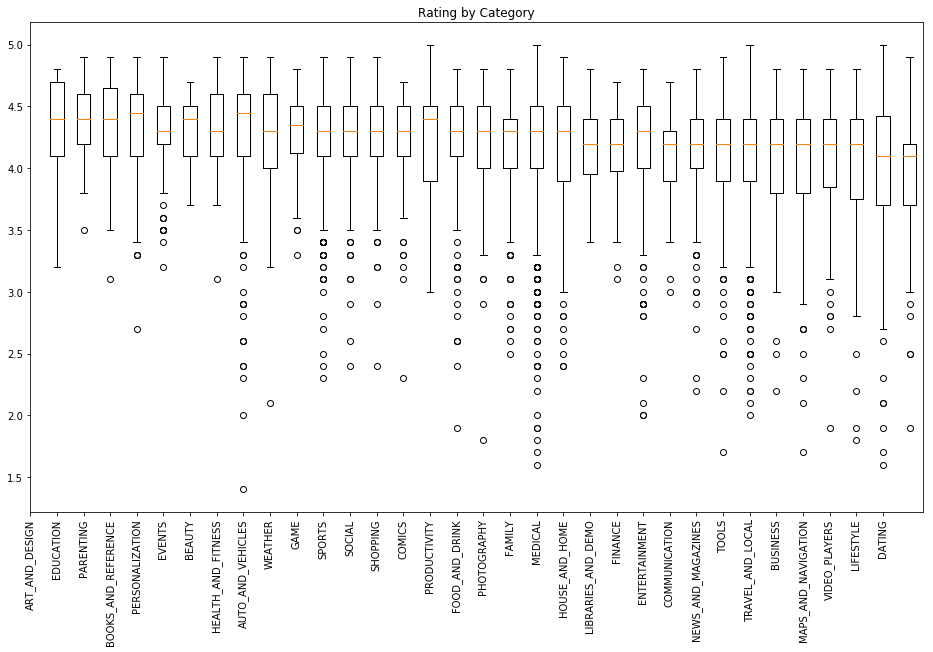

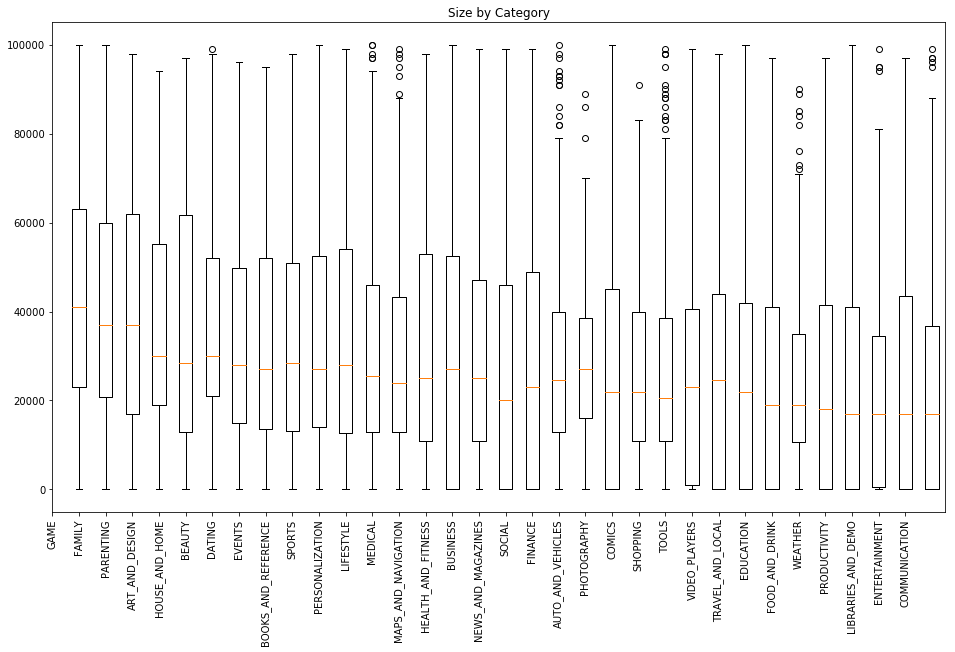

In [117]:
#compare installs & ratings by categories

def get_box_val(d, cate_val, agg_val):
    sep = d[d[group_col] == cate_val][agg_val]
    copy_ = sep.dropna()
    tmp_l = []
    for item in copy_:
        tmp_l.append(item)
    copy_ = pd.Series(np.array(tmp_l))
    return copy_

def sbs_box(d, group_col, val_col):
    #mean_rating_by_cate = d.groupby(group_col).Rating.sum() / d.groupby(group_col).Rating.count()

    #extract data to plot each boxplot
    box_data_arr = []
    for cate in categories:
        box_data_arr.append(get_box_val(d, cate, val_col))
        
    #sort data by mean of each boxplot
    sort_by_val = pd.DataFrame({
            'cate_':categories,
            'box_data':box_data_arr
        })
    
    sort_by_val['box_mean'] = sort_by_val['box_data'].apply(lambda x: x.sum()/len(x))
    sort_by_val.sort_values('box_mean', ascending=False, inplace=True)
    
    pylab.rcParams['figure.figsize'] = (16, 9)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    f = ax.boxplot(sort_by_val['box_data'])
    ax.set_xticks(range(len(sort_by_val)))
    ax.set_xticklabels(sort_by_val['cate_'], rotation=90)
    ax.set_title('{} by {}'.format(val_col, group_col))
    plt.show()
    
#compare rating & size distributions by category
categories = df_apps.Category.value_counts().keys()
sbs_box(df_apps, 'Category', 'Rating')
sbs_box(df_apps, 'Category', 'Size')


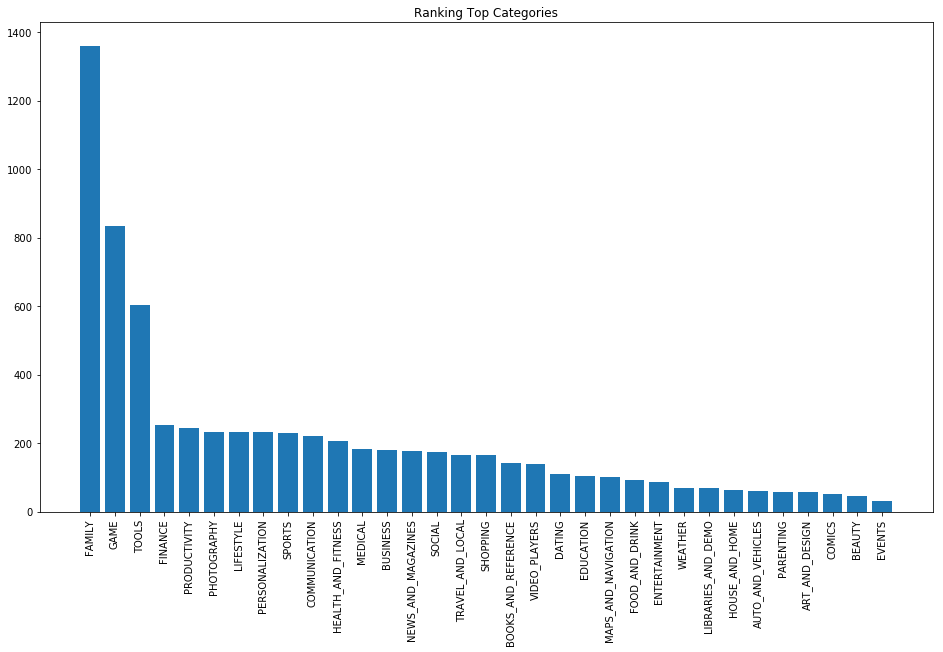

In [128]:
#rank number of apps by categories
app_counts = df_apps.Category.value_counts()

fig = plt.figure()
ax = fig.add_subplot(111)

xs = list(range(len(app_counts)))
ax.bar(xs, app_counts)
ax.set_xticks(xs)
ax.set_xticklabels(app_counts.keys(), rotation=90)
ax.set_title('Ranking Top Categories')


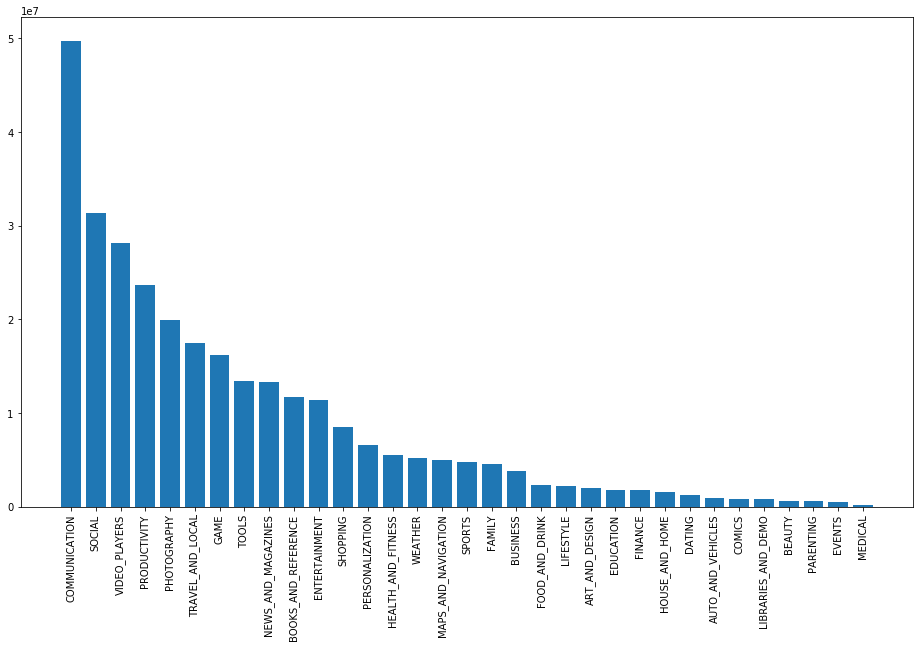

In [105]:
#rank average insatlls
#to do
    #add a subplot: bar graph of number of apps

def rank_avg_installs(d):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    category_counts = d.Category.value_counts()
    xs = list(range(len(category_counts)))
    ax.bar(xs, height=category_counts)
    ax.set_xticks(xs)
    ax.set_xticklabels(category_counts.keys(), rotation=90)
    plt.show()

categories = df_apps.Category.value_counts().keys()
pylab.rcParams['figure.figsize'] = (16, 9)
plt.figure()

means = []
for cate in categories:
    group_ = df_apps[df_apps.Category == cate]['installs_int']
    means.append(group_.mean())
    
sort_by_mean = pd.DataFrame({
        'cate_':categories,
        'means_':means
    })
sort_by_mean.sort_values('means_', ascending=False, inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111)

xs = list(range(len(sort_by_mean)))
ax.bar(xs, height=sort_by_mean.means_)
ax.set_xticks(xs)
ax.set_xticklabels(sort_by_mean.cate_, rotation=90)

plt.show()

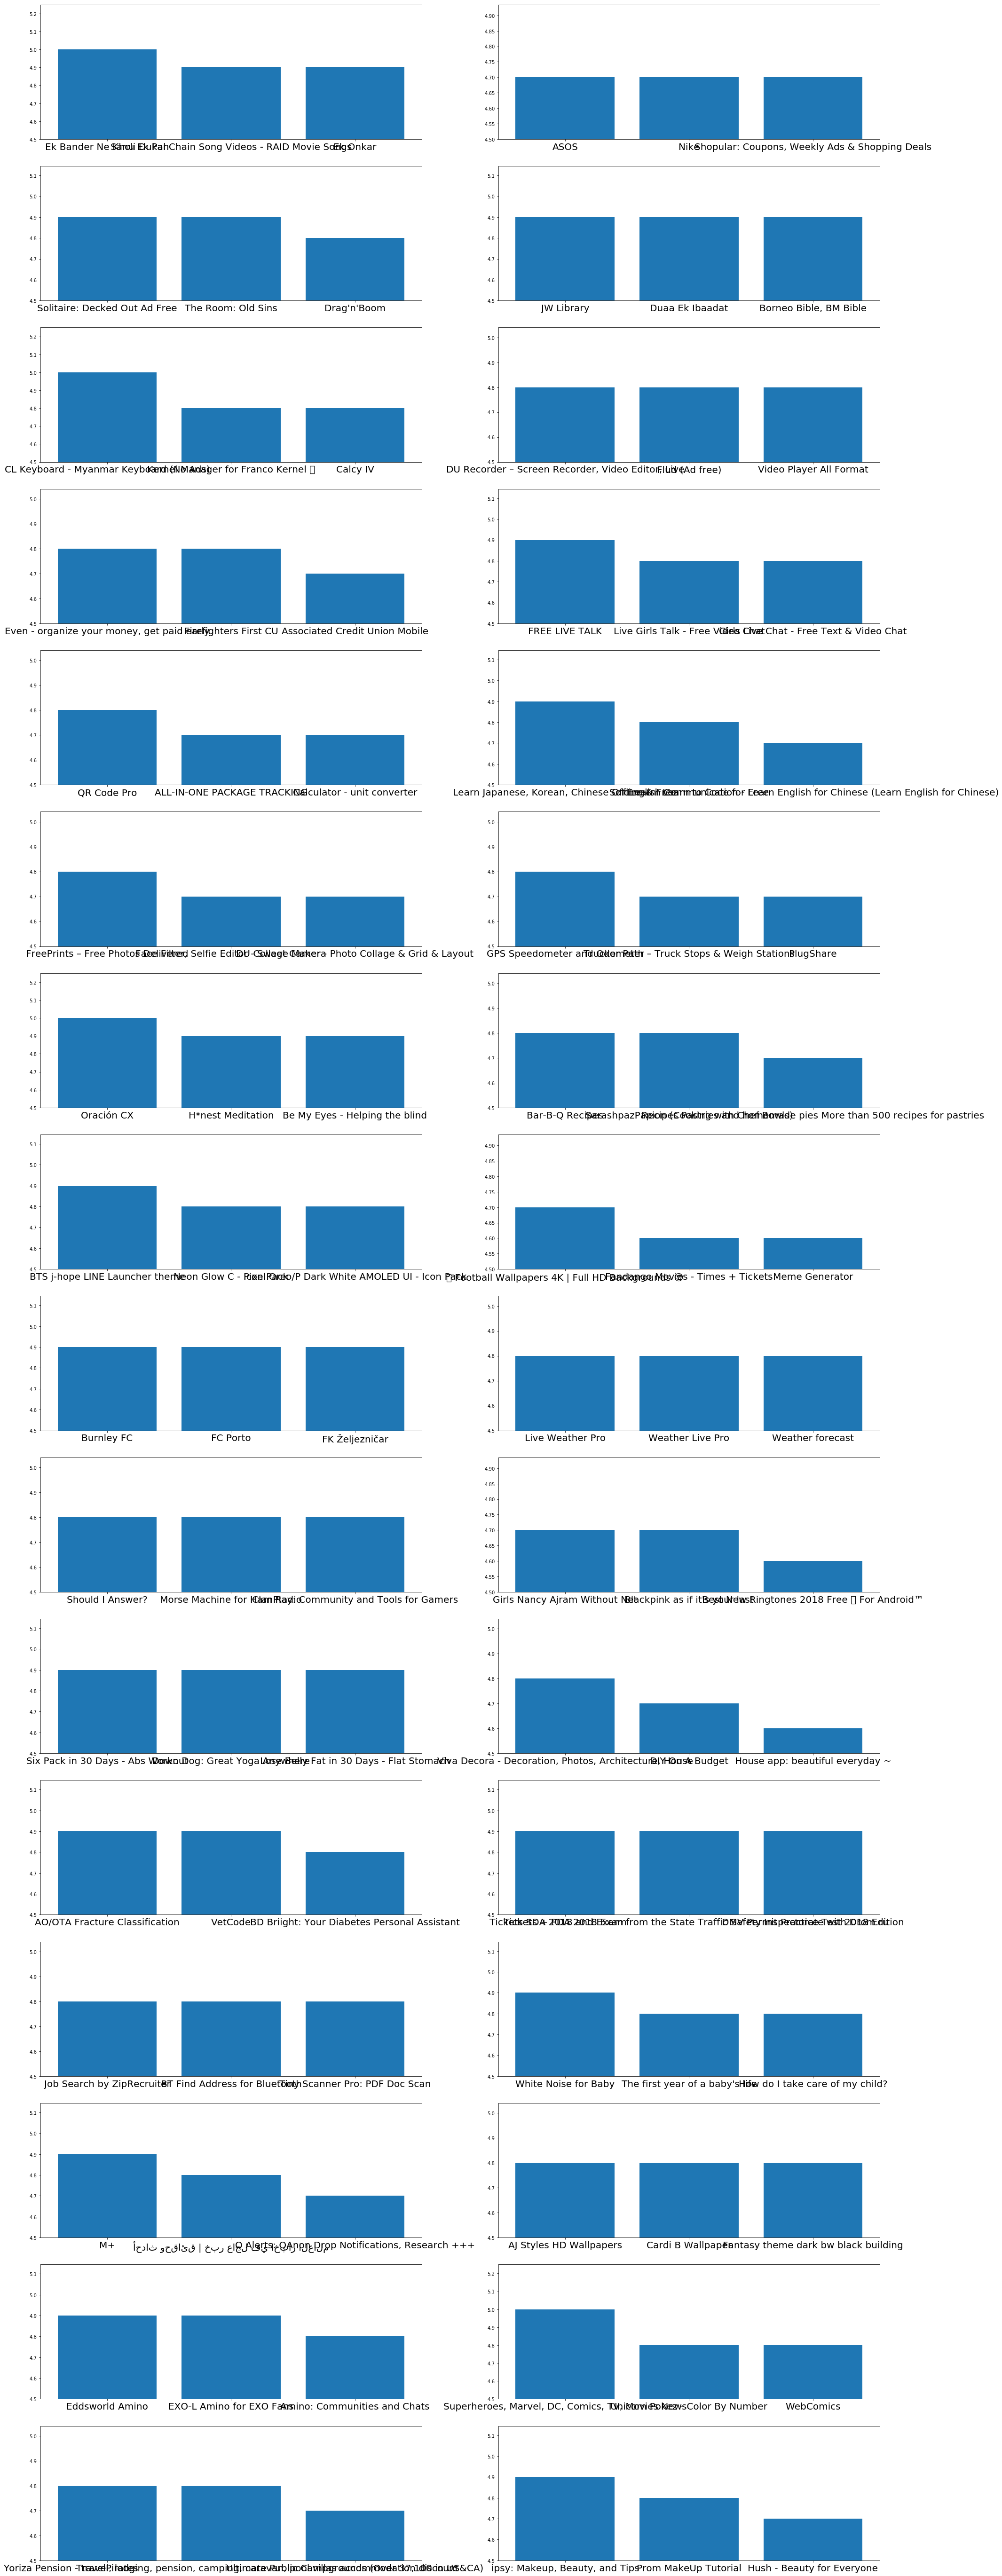

In [159]:
#top apps in categories

def plot_tops(row_in_group, ax):
    xs = list(range(len(row_in_group)))
    ax.bar(xs, row_in_group['Rating'])
    ax.set_xticks(xs)
    ax.set_xticklabels(row_in_group['App'], fontsize=20)
    ax.set_ylim(ymin=4.5)

pylab.rcParams['figure.figsize'] = (32, 100)
categories = df_apps.Category.value_counts().keys()
col_num = 2
n = len(categories)//col_num
f, axarr = plt.subplots(n, col_num)

k = 0
for i_col in range(col_num):
    for i_row in range(n):
    
        cate = categories[k]
        ax = axarr[i_row][i_col]
        
        rows_in_group = df_apps[df_apps['Category'] == cate]
        rows_in_group = rows_in_group.sort_values(by='Rating', ascending=False)[['App','Rating']][:3]
        plot_tops(rows_in_group, ax)
        
        k+=1
    
plt.show()


In [130]:
df_apps.Category.value_counts()

FAMILY                 1360
GAME                    834
TOOLS                   603
FINANCE                 254
PRODUCTIVITY            245
PHOTOGRAPHY             234
LIFESTYLE               232
PERSONALIZATION         232
SPORTS                  231
COMMUNICATION           222
HEALTH_AND_FITNESS      207
MEDICAL                 184
BUSINESS                181
NEWS_AND_MAGAZINES      178
SOCIAL                  175
TRAVEL_AND_LOCAL        166
SHOPPING                164
BOOKS_AND_REFERENCE     142
VIDEO_PLAYERS           140
DATING                  110
EDUCATION               105
MAPS_AND_NAVIGATION     101
FOOD_AND_DRINK           92
ENTERTAINMENT            87
WEATHER                  70
LIBRARIES_AND_DEMO       68
HOUSE_AND_HOME           64
AUTO_AND_VEHICLES        59
PARENTING                57
ART_AND_DESIGN           56
COMICS                   53
BEAUTY                   45
EVENTS                   31
Name: Category, dtype: int64

In [ ]:
df_apps.columns

In [148]:
10//3

3